In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.sandwich_covariance import cov_hac

92 rows x 4 columns
                y  x1
t                    
2023-07-01  87532   0
2023-07-02  75398   0
2023-07-03  32147   0
2023-07-04  36092   0
2023-07-05  38401   0
                y  x1
t                    
2023-09-26  32599   0
2023-09-27  34844   0
2023-09-28  33953   0
2023-09-29  39299   0
2023-09-30  89105   0


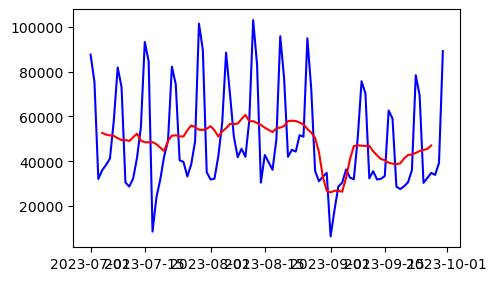

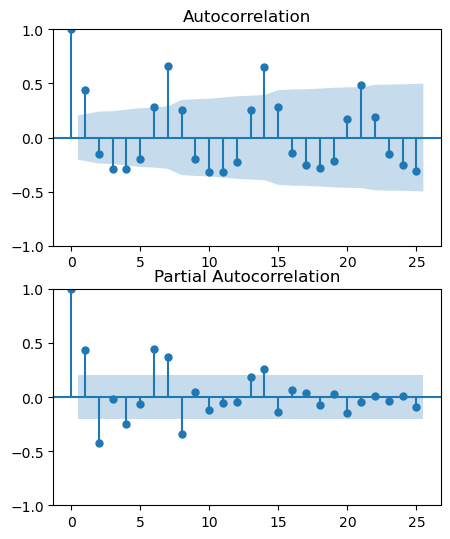

In [2]:
# Import Data

df = pd.DataFrame(pd.read_excel(r'~/Desktop/Anaconda Programs/Datasets/TS_Sample_Sales.xlsx',
                                sheet_name = 'sheet1',
                                index_col = False))
# freq_c = 'D'

# print(df.describe())
print(f'{df.shape[0]} rows x {df.shape[1]} columns')

df = df[['t','y','x1']].dropna()
# df = df[['t','y']].dropna()


df['t'] = pd.to_datetime(df[df.columns[0]])
df = df.set_index('t')
# df.index = pd.DatetimeIndex(df.index).to_period(freq_c)
print(df.head())
print(df.tail())

# Plot the data and overall trend
plt.figure(figsize=(5,5*0.618))
plt.plot(df.index, df['y'], c= 'blue')
plt.plot(sm.tsa.seasonal_decompose(df[['y']], model = 'additive').trend.index,
        sm.tsa.seasonal_decompose(df[['y']], model = 'additive').trend, c = 'red')
plt.show()


# ACF and PACF plots

fig, ax = plt.subplots(2, figsize = (5,10*0.618))
ax[0] = plot_acf(df['y'], ax = ax[0], lags = 25)
ax[1] = plot_pacf(df['y'], ax = ax[1], lags = 25)

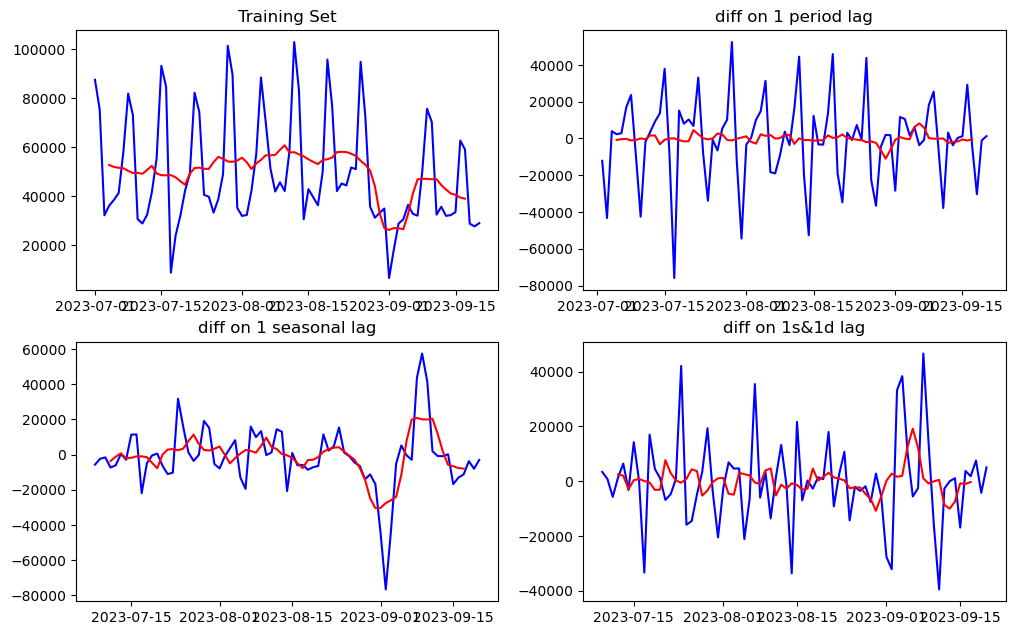

Training set/test set split successfully.
Size of training set: 82
Size of test set: 10

ADF Test Result (training)
Training set: 0.6299
d(1): 0.0
D(1): 0.0507
(d,D) = (1,1): 0.0046


In [25]:
# Data split

test_n = 10
season = 7
start = 0

if start >= df.shape[0] - test_n:
    print("ERROR: training data < 0")
# exog1 = None
# exog2 = None
# position = 2

train_n = df.shape[0] - test_n
y_train = df['y'][start:train_n]
y_test = df['y'][train_n:]

# ratio = 0.2
# test_n = df.shape[0]*ratio

x_train = df[['x1']][start:train_n]
x_test = df[['x1']][train_n:]
exog1 = x_train
exog2 = x_test
# position = 2+x_train.shape[1]

############################
def lag1(data):
    return(data-data.shift(1)).dropna()

def lags(data):
    return(data-data.shift(season)).dropna()

plt.figure(figsize=(6*2,6*2*0.618))
plt.subplot(2,2,1)
plt.plot(y_train.index, y_train, c= 'blue')
plt.plot(sm.tsa.seasonal_decompose(y_train, model = 'additive').trend.index,
        sm.tsa.seasonal_decompose(y_train, model = 'additive').trend, c = 'red')
plt.title('Training Set')
plt.subplot(2,2,2)
plt.plot(lag1(y_train).index, lag1(y_train), c= 'blue')
plt.plot(sm.tsa.seasonal_decompose(lag1(y_train), model = 'additive').trend.index,
        sm.tsa.seasonal_decompose(lag1(y_train), model = 'additive').trend, c = 'red')
plt.title('diff on 1 period lag')
plt.subplot(2,2,3)
plt.plot(lags(y_train).index, lags(y_train), c= 'blue')
plt.plot(sm.tsa.seasonal_decompose(lags(y_train), model = 'additive').trend.index,
        sm.tsa.seasonal_decompose(lags(y_train), model = 'additive').trend, c = 'red')
plt.title('diff on 1 seasonal lag')
plt.subplot(2,2,4)
plt.plot(lags(lag1(y_train)).index, lags(lag1(y_train)), c= 'blue')
plt.plot(sm.tsa.seasonal_decompose(lags(lag1(y_train)), model = 'additive').trend.index,
        sm.tsa.seasonal_decompose(lags(lag1(y_train)), model = 'additive').trend, c = 'red')
plt.title('diff on 1s&1d lag')
plt.show()

print("Training set/test set split successfully.")
print(f'Size of training set: {len(y_train)}')
print(f'Size of test set: {len(y_test)}')
print("")

print("ADF Test Result (training)")
print(f'Training set: {round(adfuller(y_train)[1], 4)}')
print(f'd(1): {round(adfuller(lag1(y_train))[1],4)}')
print(f'D(1): {round(adfuller(lags(y_train))[1],4)}')
print(f'(d,D) = (1,1): {round(adfuller(lag1(lags(y_train)))[1],4)}')

# Model Summary

def sarima_summary(mp, exog, y_train=y_train, y_test=y_test):
    # Rerun the model and the serial correlation tests
    m1 = ARIMA(y_train, exog = exog, order = (mp[0],mp[1],mp[2]), seasonal_order = (mp[3],mp[4],mp[5],season), freq = None)
    m1_bg = acorr_breusch_godfrey(m1.fit(), nlags = season)
    m1_lb = acorr_ljungbox(m1.fit().resid, lags = season)
    # m1_hac = cov_hac(m1.fit())
    y_test_resid = np.array(y_test - m1.fit().get_prediction(start = len(y_train),
                                                                 end = len(y_train)+len(y_test)-1, exog = exog2).summary_frame()['mean'])
    m1_test_mse = np.sum(y_test_resid**2)/len(y_test_resid)
    # Manual serial correlation check
    sr_pr = list(range(season))
    sr_pv_table = pd.DataFrame(columns = ['sr_p_value'])
    for i in sr_pr:
        pvalue_list = list(ARIMA(m1.fit().resid, exog = exog, order = (season,0,0)).fit().pvalues[1+exog1.shape[1]:-1])
        sr_pv_table.loc[i+1] = pvalue_list[i]
#         [float(ARIMA(m1.fit().resid, exog = exog,order = (season,0,0)).fit().summary().tables[1].data[i+position][4].strip())]
    print(f'Model = {mp} at s = {season}')
    print(f'AIC = {round(m1.fit().aic,4)}')
    print(f'BGodfrey p-value = {round(m1_bg[1],4)} (test stc = {round(m1_bg[0],4)} at {season} lags)')
    print(f"LBox p-value = {list(round(m1_lb['lb_pvalue'],4))} at {season} lags")
    print(f"Test MSE = {m1_test_mse}")
    # print(f"HAC = {m1_hac}")
    print("")
    if sr_pv_table[sr_pv_table['sr_p_value']< 0.05].shape[0] == 0:
        print("No significant serial correlation")
    else:
        print(f"Serial correlation exists in p = {list(sr_pv_table[sr_pv_table['sr_p_value']< 0.05].index)}")
        print(f"p = {[round(x,2) for x in pvalue_list]}")
    print(m1.fit().summary().tables[1])
    m1.fit().plot_diagnostics(figsize = (8,6))
    return plt.show(), m1

In [32]:
# SARIMA Model Building (new)

max_range_list = [2,1,2,1,0,2]

# Specify again if needed: exog1 = None or exog1 = x_train

# ************************************** #
import warnings
warnings.filterwarnings('ignore')

r1 = list(range(max_range_list[0]+1))
r2 = list(range(max_range_list[1]+1))
# r2 = [1,]
r3 = list(range(max_range_list[2]+1))
r4 = list(range(max_range_list[3]+1))
r5 = list(range(max_range_list[4]+1))
# r5 = [1,]
r6 = list(range(max_range_list[5]+1))
mp_list = [[p1,p2,p3,p4,p5,p6] for p1 in r1 for p2 in r2 for p3 in r3 for p4 in r4 for p5 in r5 for p6 in r6]
LinAlgError_list = []

model_table = pd.DataFrame(columns = ['Model','AIC','BG(p)','Test_MSE', 'n_insig_est'])

for i in range(len(mp_list)):
    try:
        m1 = ARIMA(y_train, exog = exog1, order = (mp_list[i][0],mp_list[i][1],mp_list[i][2]),
                    seasonal_order = (mp_list[i][3],mp_list[i][4],mp_list[i][5],season),
                    freq = None)
        m1_aic = round(m1.fit().aic,4)
        m1_bg = acorr_breusch_godfrey(m1.fit(), nlags = season)[1]
        y_test_resid = np.array(y_test - m1.fit().get_prediction(start = len(y_train),
                                                                 end = len(y_train)+len(y_test)-1, exog = exog2).summary_frame()['mean'])
        m1_test_mse = np.sum(y_test_resid**2)/len(y_test_resid)
        m1_insignificant_estimator = np.sum([1 if x>0.05 else 0 for x in list(m1.fit().pvalues)])
        model_table.loc[i] = [mp_list[i], m1_aic, m1_bg, m1_test_mse, m1_insignificant_estimator]
    except np.linalg.LinAlgError:
        m1 = ARIMA(y_train, exog = exog1, order = (mp_list[i][0],mp_list[i][1],mp_list[i][2]),
                    seasonal_order = (mp_list[i][3],mp_list[i][4],mp_list[i][5],season),
                    freq = None)
        model_table.loc[i] = [mp_list[i], 0, 0, 0, 0]
        LinAlgError_list.append(mp_list[i])
    else:
        print(f'Progress: {int(100*(i+1)/len(mp_list))}%', end = '\r')

print("Progress: 100% (Done)")
print("")
print("Sorted by lowest Test_MSE with BG(p) > 0.05")
print("")
print(model_table[model_table['BG(p)'] > 0.05].sort_values(by = ['Test_MSE'], ascending = [True]).head())
print("")
print("Sorted by lowest AIC with BG(p) > 0.05")
print("")
print(model_table[model_table['BG(p)'] > 0.05].sort_values(by = ['AIC'], ascending = [True]).head())
if len(LinAlgError_list) > 0:
    print("")
    print(f'Error when processing model: {LinAlgError_list}')

# Automatically choose the "BEST" model in model_table
best_mp = model_table['Model'][model_table[model_table['BG(p)'] > 0.05].sort_values(by=['AIC'],ascending=[True])['Model'].index[0]]
# # Build the "BEST" model (print and store_value)
# m1 = sarima_summary(mp=mp, exog=exog1)[1]

Progress: 100% (Done)

Sorted by lowest Test_MSE with BG(p) > 0.05

                 Model        AIC     BG(p)      Test_MSE  n_insig_est
28  [1, 1, 1, 1, 0, 1]  1796.6418  0.150533  1.053808e+08            3
34  [1, 1, 2, 1, 0, 1]  1739.8250  0.377489  1.102740e+08            3
52  [2, 1, 2, 1, 0, 1]  1739.9563  0.413901  1.110328e+08            4
29  [1, 1, 1, 1, 0, 2]  1798.4479  0.140895  1.219419e+08            4
16  [0, 1, 2, 1, 0, 1]  1765.6896  0.368706  1.495853e+08            2

Sorted by lowest AIC with BG(p) > 0.05

                 Model        AIC     BG(p)      Test_MSE  n_insig_est
34  [1, 1, 2, 1, 0, 1]  1739.8250  0.377489  1.102740e+08            3
52  [2, 1, 2, 1, 0, 1]  1739.9563  0.413901  1.110328e+08            4
35  [1, 1, 2, 1, 0, 2]  1740.5864  0.321233  1.582446e+08            4
53  [2, 1, 2, 1, 0, 2]  1740.6157  0.353283  1.579290e+08            5
15  [0, 1, 2, 1, 0, 0]  1756.5639  0.404410  1.963148e+08            0


Model = [1, 1, 2, 1, 0, 1] at s = 7
AIC = 1739.825
BGodfrey p-value = 0.3775 (test stc = 7.513 at 7 lags)
LBox p-value = [0.8343, 0.6803, 0.8185, 0.9193, 0.9507, 0.6866, 0.7871] at 7 lags
Test MSE = 110274006.07773443

Serial correlation exists in p = [6]
p = [0.43, 0.32, 0.75, 0.76, 0.65, 0.02, 0.98]
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -3.249e+04   7902.713     -4.112      0.000    -4.8e+04    -1.7e+04
ar.L1          0.2873      0.360      0.798      0.425      -0.418       0.993
ma.L1         -0.5374      0.305     -1.759      0.079      -1.136       0.061
ma.L2         -0.3264      0.202     -1.613      0.107      -0.723       0.070
ar.S.L7        0.9635      0.053     18.068      0.000       0.859       1.068
ma.S.L7       -0.7640      0.206     -3.711      0.000      -1.168      -0.360
sigma2      1.568e+08      0.141   1.11e+09      0.000    1.57e+0

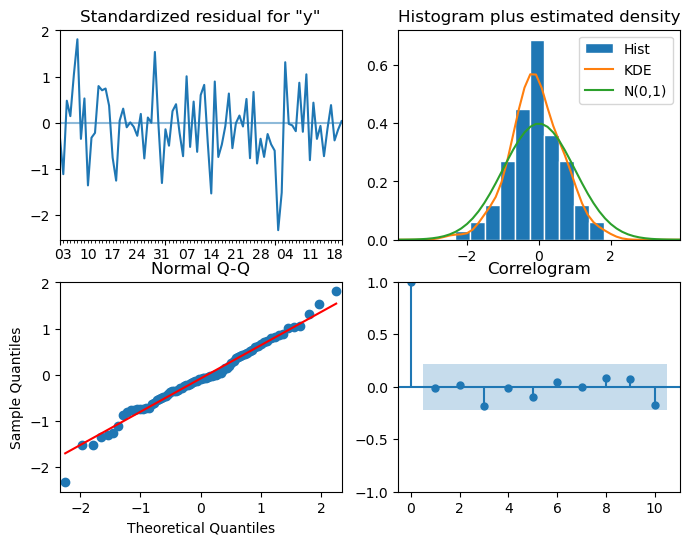

In [35]:
# SARIMA Summary

mp = [1,1,2,1,0,1]
# mp = best_mp
# mp = mp_list[40]

# Specify again if needed exog1 = None or exog1 = x_train
# Specify again if needed position = 2 (no exog) or position = 2+x_train.shape[1] (exog exists)
###################
m1 = sarima_summary(mp=mp, exog=exog1)[1]

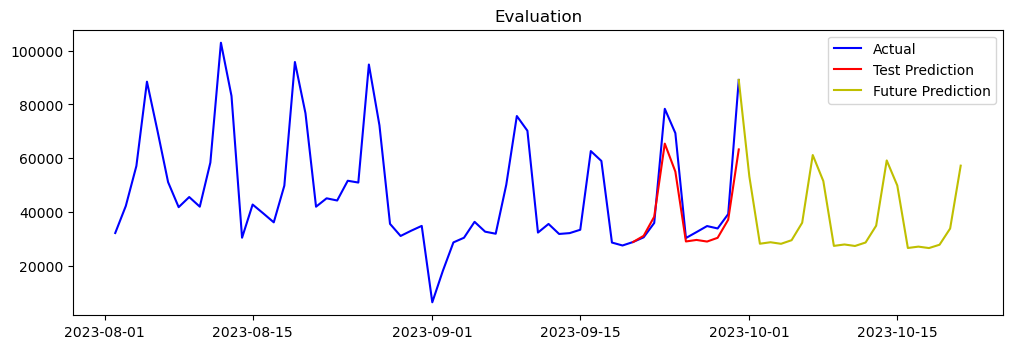

In [30]:
# Check if exog is needed

exog2 = x_test
# exog2 = None

forecast_period_future = 21
exog3_range = forecast_period_future + len(y_test)
exog3 = pd.DataFrame({'x1':[0 for i in list(range(exog3_range))]},
             index = pd.to_datetime([i for i in list(range(exog3_range))],unit='D',origin=pd.Timestamp(y_test.index[-1])))
# exog3 = None

##################

# Make predictions and compare with test data

get_predictions = m1.fit().get_prediction(start = len(y_train)-1, end = len(y_train)+len(y_test)-1, exog = exog2)

df_pred = pd.DataFrame({'actual':pd.concat([y_train,y_test]),
              'predictions':pd.concat([y_train[len(y_train)-1:],get_predictions.summary_frame()['mean'][1:]]), 
              'residuals':get_predictions.summary_frame()['mean'][1:] - y_test})


get_predictions_2 = m1.fit().get_prediction(start = len(y_train)+len(y_test)-1, 
                                     end = len(y_train)+len(y_test)+forecast_period_future-1, 
                                     exog = exog3)

zoom_start = len(y_train)-min(len(y_train),5*y_test.shape[0])

# Plot the overall performance and future prediction

ci_level = 0.95
plt.figure(figsize=(6*2,6*0.618))
plt.plot(pd.concat([y_train[zoom_start:],y_test]), "b-", label = "Actual")
# plt.plot(pd.concat([y_train[:],y_test]), "b-", label = "Actual")
plt.plot(pd.concat([y_train[len(y_train)-1:],get_predictions.summary_frame()['mean'][1:]]), "r-", label = "Test Prediction")
plt.plot(pd.concat([y_test[len(y_test)-1:],get_predictions_2.summary_frame()['mean'][1:]]), "y-", label = "Future Prediction")
plt.title('Evaluation')
plt.legend(loc = "best")

In [36]:
# Old version of prediction evaluation
# # Make predictions

# exog2 = x_test
# # exog2 = None

# forecast_period_future = 14
# exog3_range = forecast_period_future + len(y_test)
# exog3 = pd.DataFrame({'x1':[0 for i in list(range(exog3_range))]},
#              index = pd.to_datetime([i for i in list(range(exog3_range))],unit='D',origin=pd.Timestamp(y_test.index[-1])))
# # exog3 = None

# ##################

# # forecast_period = y_test.shape[0]

# get_predictions = m1.fit().get_prediction(start = len(y_train)-1, end = len(y_train)+len(y_test)-1, exog = exog2)

# df_pred = pd.DataFrame({'actual':pd.concat([y_train,y_test]),
#               'predictions':pd.concat([y_train[len(y_train)-1:],get_predictions.summary_frame()['mean'][1:]]), 
#               'residuals':get_predictions.summary_frame()['mean'][1:] - y_test})

# zoom_start = len(y_train)-min(len(y_train),3*y_test.shape[0])

# # Setting up for further predictions (red dash = 2 sigma (0.95) and yellow dash = 1 sigma (0.68))

# # forecast_period_future = 24

# get_predictions_2 = m1.fit().get_prediction(start = len(y_train)+len(y_test)-1, 
#                                      end = len(y_train)+len(y_test)+forecast_period_future-1, 
#                                      exog = exog3)

# # zoom_start_2 = len(y_train)+len(y_test)-min(len(y_train)+len(y_test),2*forecast_period_future)

# # Examine the prediction (Plot 1)
# ci_level = 0.95
# plt.figure(figsize=(6*2,6*0.618))
# plt.subplot(1,2,1)
# plt.plot(pd.concat([y_train[zoom_start:],y_test]), "b-", label = "Actual")
# plt.plot(pd.concat([y_train[len(y_train)-1:],get_predictions.summary_frame()['mean'][1:]]), "r-", label = "Prediction")
# plt.plot(get_predictions.summary_frame(alpha = 1-ci_level)["mean_ci_lower"], "r--")
# plt.plot(get_predictions.summary_frame(alpha = 1-ci_level)["mean_ci_upper"], "r--")
# plt.fill_between(get_predictions.summary_frame(alpha = 1-ci_level).index,
#                  get_predictions.summary_frame(alpha = 1-ci_level)["mean_ci_lower"],
#                  get_predictions.summary_frame(alpha = 1-ci_level)["mean_ci_upper"],
#                  alpha = 0.2)
# plt.title('Test Set Prediction')
# plt.legend(loc = "upper left")

# # Make the prediction (Plot 2)
# plt.subplot(1,2,2)
# plt.plot(pd.concat([y_train,y_test])[zoom_start:], label = 'Past Record')
# plt.plot(pd.concat([y_test[len(y_test)-1:],get_predictions_2.summary_frame()['mean'][1:]]), "r-", label = "Future Prediction")
# plt.plot(get_predictions_2.summary_frame(alpha = 1-0.95)["mean_ci_lower"], "r--") # ,label = "CI at 0.95"
# plt.plot(get_predictions_2.summary_frame(alpha = 1-0.95)["mean_ci_upper"], "r--")
# plt.plot(get_predictions_2.summary_frame(alpha = 1-0.68)["mean_ci_lower"], "y--") # ,label = "CI at 0.68"
# plt.plot(get_predictions_2.summary_frame(alpha = 1-0.68)["mean_ci_upper"], "y--")
# plt.fill_between(get_predictions_2.summary_frame(alpha = 1-0.95).index, 
#                  get_predictions_2.summary_frame(alpha = 1-0.95)["mean_ci_lower"], 
#                  get_predictions_2.summary_frame(alpha = 1-0.95)["mean_ci_upper"],
#                  alpha = 0.2)
# plt.title('Future Prediction')
# plt.legend(loc = "best")
# plt.show()

In [ ]:
#######################################
# END HERE
#######################################

In [22]:
# # Make predictions

# exog2 = x_test
# # exog2 = None
# forecast_period = y_test.shape[0]

# get_predictions = m1.fit().get_prediction(start = len(y_train)-1, end = len(y_train)+len(y_test)-1, exog = exog2)

# df_pred = pd.DataFrame({'actual':pd.concat([y_train,y_test]),
#               'predictions':pd.concat([y_train[len(y_train)-1:],get_predictions.summary_frame()['mean'][1:]]), 
#               'residuals':get_predictions.summary_frame()['mean'][1:] - y_test})

# zoom_start = len(y_train)-min(len(y_train),3*forecast_period)

# # Setting up for further predictions (red dash = 2 sigma (0.95) and yellow dash = 1 sigma (0.68))

# # exog3 = None
# exog3 = pd.DataFrame({'x1':[0 for i in list(range(36))]},
#              index = pd.to_datetime([i for i in list(range(36))],unit='D',origin=pd.Timestamp(y_test.index[-1])))
# forecast_period_2 = 24

# get_predictions_2 = m1.fit().get_prediction(start = len(y_train)+len(y_test)-1, 
#                                      end = len(y_train)+len(y_test)+forecast_period_2-1, 
#                                      exog = exog3)

# zoom_start_2 = len(y_train)+len(y_test)-min(len(y_train)+len(y_test),3*forecast_period_2)



# # Examine the prediction

# ci_level = 0.95
# fig2, ax2 = plt.subplots(figsize = (10,6))
# ax2.plot(pd.concat([y_train[zoom_start:],y_test]), "b-", label = "Actual")
# ax2.plot(pd.concat([y_train[len(y_train)-1:],get_predictions.summary_frame()['mean'][1:]]), "r-", label = "Prediction")
# ax2.plot(get_predictions.summary_frame(alpha = 1-ci_level)["mean_ci_lower"], "r--")
# ax2.plot(get_predictions.summary_frame(alpha = 1-ci_level)["mean_ci_upper"], "r--")
# ax2.fill_between(get_predictions.summary_frame(alpha = 1-ci_level).index,
#                  get_predictions.summary_frame(alpha = 1-ci_level)["mean_ci_lower"],
#                  get_predictions.summary_frame(alpha = 1-ci_level)["mean_ci_upper"],
#                  alpha = 0.2)
# ax2.legend(loc = "upper left")
# plt.show()

In [21]:
# # Setting up for further predictions (red dash = 2 sigma (0.95) and yellow dash = 1 sigma (0.68))

# # exog3 = None
# exog3 = pd.DataFrame({'x1':[0 for i in list(range(36))]},
#              index = pd.to_datetime([i for i in list(range(36))],unit='D',origin=pd.Timestamp(y_test.index[-1])))
# forecast_period_2 = 24

# get_predictions_2 = m1.fit().get_prediction(start = len(y_train)+len(y_test)-1, 
#                                      end = len(y_train)+len(y_test)+forecast_period_2-1, 
#                                      exog = exog3)

# zoom_start_2 = len(y_train)+len(y_test)-min(len(y_train)+len(y_test),3*forecast_period_2)

# # Prediction the ongoing trend

# fig2, ax2 = plt.subplots(figsize = (10,6))
# ax2.plot(pd.concat([y_train,y_test])[zoom_start_2:], label = 'past_record')
# ax2.plot(pd.concat([y_test[len(y_test)-1:],get_predictions_2.summary_frame()['mean'][1:]]), "r-", label = "Prediction")
# ax2.plot(get_predictions_2.summary_frame(alpha = 1-0.95)["mean_ci_lower"], "r--", label = "CI at 0.95")
# ax2.plot(get_predictions_2.summary_frame(alpha = 1-0.95)["mean_ci_upper"], "r--")
# ax2.plot(get_predictions_2.summary_frame(alpha = 1-0.68)["mean_ci_lower"], "y--", label = "CI at 0.68")
# ax2.plot(get_predictions_2.summary_frame(alpha = 1-0.68)["mean_ci_upper"], "y--")


# ax2.fill_between(get_predictions_2.summary_frame(alpha = 1-0.95).index, 
#                  get_predictions_2.summary_frame(alpha = 1-0.95)["mean_ci_lower"], 
#                  get_predictions_2.summary_frame(alpha = 1-0.95)["mean_ci_upper"],
#                  alpha = 0.2)

# ax2.legend(loc = "best")
# plt.show()

In [ ]:
# Chow test?

In [28]:
# # Export predictions

# df_pred[1:].to_excel(r'~/Desktop/Anaconda Programs/Predictions/Prediction01.xlsx', index = True, header = False)
# print('Export Complete')

In [ ]:
### Extra notes

In [108]:
# # SARIMA Model Building (Part 2: d,D=0,1)
# # Settings: prmt = (0,2), season = 7, exog = None

# import warnings
# warnings.filterwarnings('ignore')

# prmt_max = 2      # setting max values for (p,d,q,P,D,Q)
# season = 7      # setting seasonality factor (s)
# # freq_c = 'Q'

# from itertools import product
# mp_list = list(product(list(range(prmt_max+1)),repeat = 4))

# from statsmodels.tsa.arima.model import ARIMA
# model_table = pd.DataFrame(columns = ['Model','AIC','BG(p)', 'AIC_test', 'mse_test'])

# for i in range(len(mp_list)):
#     if len(mp_list[i]) ==4:
#         mp_list[i] = list(mp_list[i])
#         mp_list[i].insert(1,0)
#         mp_list[i].insert(4,1)

# for i in range(len(mp_list)):
#     m1 = ARIMA(y_train, exog = None, order = (mp_list[i][0],mp_list[i][1],mp_list[i][2]),
#               seasonal_order = (mp_list[i][3],mp_list[i][4],mp_list[i][5],season),
#               freq = None)
#     m1_aic = round(m1.fit().aic,4)
#     m1_bg = acorr_breusch_godfrey(m1.fit())[1]
#     m2 = ARIMA(y_test, exog = None, order = (mp_list[i][0],mp_list[i][1],mp_list[i][2]),
#               seasonal_order = (mp_list[i][3],mp_list[i][4],mp_list[i][5],season),
#               freq = None)
#     m2_aic = round(m2.fit().aic,4)
#     m2_mse = np.log(sum(m2.fit().resid**2)/test_n)
# #     m2_bg = acorr_breusch_godfrey(m2.fit())[1]
#     model_table.loc[i] = [mp_list[i], m1_aic, m1_bg, m2_aic, m2_mse]
#     print(f'Progress: {int(round(100*(i+1)/len(mp_list),0))}%', end = '\r')

# print("Progress: 100% (Done)")
# print("")
# if model_table[model_table['BG(p)'] < 0.05].sort_values(by=['AIC'],ascending=[True]).shape[0] >0:
#     print("Sorted by lowest AIC and no significant serial correlation (BG(p) < 0.05)")
#     print("")
#     print(model_table[model_table['BG(p)']<0.05].sort_values(by=['AIC'], ascending = [True]).head())
#     print("")
#     print("Sorted by lowest AIC")
#     print("")
#     print(model_table.sort_values(by = ['AIC'], ascending = [True]).head())
# else:
#     print("Sorted by lowest AIC")
#     print("")
#     print(model_table.sort_values(by = ['AIC'], ascending = [True]).head())
#     print("")
#     print("Sorted by lowest BG(p)")
#     print("")
#     print(model_table.sort_values(by = ['BG(p)'], ascending = [True]).head())
    
# # print(model_table.sort_values(by = ['AIC'], ascending = [True]).head())

In [109]:
# model_table.sort_values(by=['BG(p)'], ascending = [False])

In [ ]:
####################################
# # Rerun the model and the serial correlation tests
# m1 = ARIMA(y_train, exog = exog1, order = (mp[0],mp[1],mp[2]), seasonal_order = (mp[3],mp[4],mp[5],season), freq = None)
# m1_bg = acorr_breusch_godfrey(m1.fit(), nlags = season)
# m1_lb = acorr_ljungbox(m1.fit().resid, lags = season)

# # Manual serial correlation check

# sr_degree = season
# sr_pr = list(range(sr_degree))
# sr_pv_table = pd.DataFrame(columns = ['sr_p_value'])
# for i in sr_pr:
#     sr_pv_table.loc[i] = [float(ARIMA(m1.fit().resid, 
#                                       exog = exog1, 
#                                       order = (sr_degree,0,0)).fit().summary().tables[1].data[i+position][4].strip())]


# print(f'Model = {mp} at s = {season}')
# print(f'AIC = {round(m1.fit().aic,4)}')
# print(f'BGodfrey p-value = {round(m1_bg[1],4)} (test stc = {round(m1_bg[0],4)} at {season} lags)')
# print(f"LBox p-value = {list(round(m1_lb['lb_pvalue'],4))} at {season} lags")
# print("")

# if sr_pv_table[sr_pv_table['sr_p_value']< 0.05].shape[0] == 0:
#     print("No significant serial correlation")
# else:
#     print(f"Serial correlation exists in p = {list(sr_pv_table[sr_pv_table['sr_p_value']< 0.05].index)}")

# print(m1.fit().summary().tables[1])
# m1.fit().plot_diagnostics(figsize = (8,6))
# plt.show()

In [ ]:
# # SARIMA Model Building (old)

# max_range_list = [3,0,3,2,0,2]
# exog1 = x_train
# position = 2+x_train.shape[1]  # if no exog then position = 2
# # exog1 = None
# # position = 2

# # ************************************** #
# import warnings
# warnings.filterwarnings('ignore')

# r1 = list(range(max_range_list[0]+1))
# r2 = list(range(max_range_list[1]+1))
# r3 = list(range(max_range_list[2]+1))
# r4 = list(range(max_range_list[3]+1))
# r5 = list(range(max_range_list[4]+1))
# r6 = list(range(max_range_list[5]+1))
# mp_list = [[p1,p2,p3,p4,p5,p6] for p1 in r1 for p2 in r2 for p3 in r3 for p4 in r4 for p5 in r5 for p6 in r6]


# model_table = pd.DataFrame(columns = ['Model','AIC','BG(p)'])

# for i in range(len(mp_list)):
#     m1 = ARIMA(y_train, exog = exog1, order = (mp_list[i][0],mp_list[i][1],mp_list[i][2]),
#               seasonal_order = (mp_list[i][3],mp_list[i][4],mp_list[i][5],season),
#               freq = None)
#     m1_aic = round(m1.fit().aic,4)
#     m1_bg = acorr_breusch_godfrey(m1.fit(), nlags = season)[1]
#     model_table.loc[i] = [mp_list[i], m1_aic, m1_bg]
#     print(f'Progress: {int(round(100*(i+1)/len(mp_list),0))}%', end = '\r')

# print("Progress: 100% (Done)")
# print("")
# if model_table[model_table['BG(p)'] > 0.05].sort_values(by=['AIC'],ascending=[True]).shape[0] >0:
#     print("Sorted by lowest AIC with BG(p) > 0.05")
#     print("")
#     print(model_table[model_table['BG(p)'] > 0.05].sort_values(by = ['AIC'], ascending = [True]).head())
# else: 
#     print("Sorted by lowest AIC only")
#     print("")
#     print(model_table.sort_values(by = ['AIC'], ascending = [True]).head())

# print("")
# print("")

# # Automatically choose the "BEST" model in model_table
# mp = model_table['Model'][model_table[model_table['BG(p)'] > 0.05].sort_values(by=['AIC'],ascending=[True])['Model'].index[0]]

# # Build the "BEST" model (print and store_value)
# m1 = sarima_summary(mp, exog1)[1]
